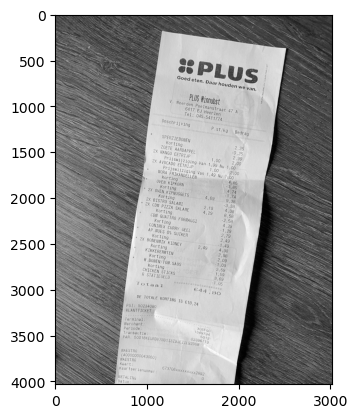

In [18]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from math import pi
from scipy.stats import linregress
from math import pi
from scipy.optimize import minimize
import time

filename = "IMG_0131.jpg"
img1 = np.array(Image.open(filename))
imgbw = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(imgbw, cmap="gray");

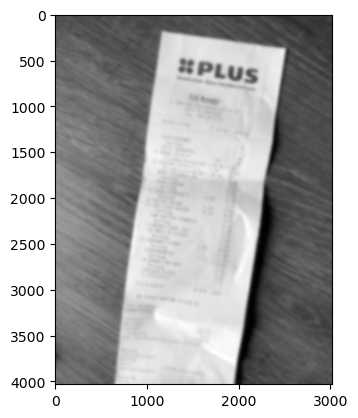

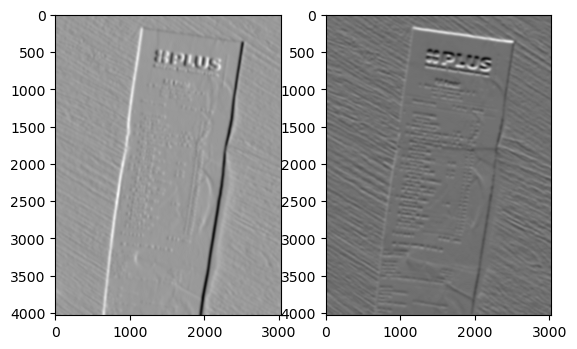

In [19]:
# blur the image
blurred = cv2.GaussianBlur(imgbw,(101,101),0)
plt.imshow(blurred, cmap="gray")
plt.show()
# compute the gradient
sobelx = cv2.Sobel(blurred,cv2.CV_64F,1,0,ksize=1)
sobely = cv2.Sobel(blurred,cv2.CV_64F,0,1,ksize=1)
fig,axs = plt.subplots(1,2)
axs[0].imshow(sobelx, cmap="gray")
axs[1].imshow(sobely, cmap="gray")


In [20]:
def venergy(gradx, x1, x2, direction, alpha=.5, beta=1, max_iter = 10000, DEBUG=False):
    #parameters:
    # gradx: gradient in horizontal direction
    # cpoints: x-values for the initial points to look at. first point is at the top, second at the bottom
    # direction: indicating if we look from right to left (direction = -1) or from left to right (direction = 1)
    # alpna: weight for the directional part
    # beta: weight for the gradient
    # max_iter: maximum number of iterations
    
    h = gradx.shape[0]
    w = gradx.shape[1]
    sum_x = h * (h + 1) // 2               
    sum_x2 = h * (h + 1) * (2 * h + 1) // 6
    denominator = h * sum_x2 - sum_x**2

    x1 = float(x1)
    x2 = float(x2)

    epsilon = 1e-3

    for i in range(max_iter):
        Y = np.arange(0,gradx.shape[0],1)
        #determine the direction of the line and assign X
        b = x1;
        a = (x2-x1)/Y[-1]
        X = (a*Y+b).astype("int32")
        grad = gradx[Y,X]
        
        # fit a line through the gradient and estimate the values at the two control points
        # the external energy is -gradient at control points (=l.intercept + l.slope*y)
        # the internal energy is forcing the line in a certain direction
        sum_y = grad.sum()                          
        sum_xy = (Y*grad).sum() 
        slope = (h * sum_xy - sum_x * sum_y) / denominator
        intercept = (sum_y * sum_x2 - sum_x * sum_xy) / denominator       
        x1_delta = -intercept + direction*alpha
        x2_delta = -(intercept + slope*Y[-1]) + direction*alpha        
        # move the line
        x1 += x1_delta
        x2 += x2_delta
        delta = np.abs(x1_delta) + np.abs(x2_delta)
        if delta < epsilon:
            break
    if DEBUG: 
        print(f"contour found after {i} iterations (delta = {delta})");
    return (x1,x2)


In [21]:

t = time.time()
(r1, r2) = venergy(sobelx, 3000,3000, -1, DEBUG=True)
(l1, l2) = venergy(sobelx, 10,10, 1, max_iter = 6000, DEBUG=True)
print(f"time elapsed: {time.time()-t}")
m1 = (r1+l1)/2
m2 = (r2+l2)/2

angle = 180*np.arctan2(m2-m1, sobelx.shape[0])/pi

def rotateback(m1, m2):
    Cx = imgbw.shape[1]//2; Cy =imgbw.shape[0]//2;

    c = np.array([Cx,Cy])
    p1 = np.array([m1, 0])
    p2 = np.array([m2, imgbw.shape[0]])

    d = np.linalg.norm(np.cross(p2-p1, p1-c))/np.linalg.norm(p2-p1)
    orientation = np.sign(np.cross(p1-c, p2-c))
    return d*orientation + Cx



contour found after 1467 iterations (delta = 0.0007641570141569964)
contour found after 1915 iterations (delta = 0.0008453325540481726)
time elapsed: 0.18091106414794922


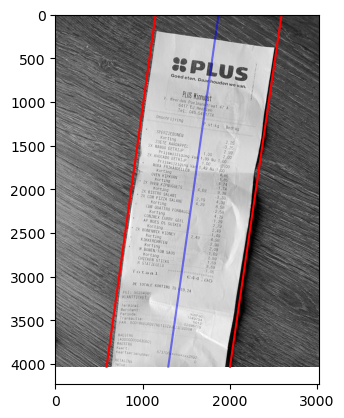

In [24]:
plt.imshow(imgbw, cmap="gray")
plt.plot([r1,r2], [0, imgbw.shape[0]],color="red")
plt.plot([l1,l2], [0, imgbw.shape[0]],color="red")
plt.plot([m1, m2], [0, imgbw.shape[0]], color = "blue", alpha = .5)

In [25]:
Cx = imgbw.shape[1]//2; Cy =imgbw.shape[0]//2;
w = imgbw.shape[1]; h = imgbw.shape[0];
M = cv2.getRotationMatrix2D((Cx, Cy), -angle, 1.0)
rotated = cv2.warpAffine(imgbw, M, (img1.shape[1], img1.shape[0]))
cropl = rotateback(l1, l2)
cropr = rotateback(r1, r2)

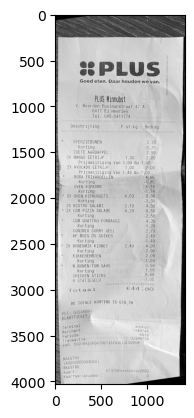

In [26]:
cropped = rotated[:,int(cropl):int(cropr)]
plt.imshow(cropped, cmap="gray");

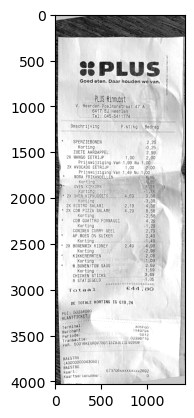

In [27]:
def automatic_brightness_and_contrast(image, clip_hist_percent=25):

    # Calculate grayscale histogram
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

adj, alpha, beta = automatic_brightness_and_contrast(cropped)
plt.imshow(adj, cmap="gray")

In [28]:
text_adj = pytesseract.image_to_string(adj)
print(text_adj)


PLUS

Goed eten. Daar houden we van.

PLUS Hinnubst

V, Weerden Poelmanstraat 47 A
6417 EJ Heerlen
Tel: 10895 ee

Wateraioe 2. 0 RW ee aa a ao

“Onsehrijving ua stlko Betray
. SPERZIEBONEN 2,25
Korting -0,25
ZOETE AARDAPPEL 2,99
2X MANGO EETRIJP 1,00 2,00
Prijswijziging Van 1,99 Nu 1,00
2X AVOCADO EETRIJP 1,00 2,00
3 Prijswijziging Van 1,49 Nu 1400
a * MORA FRIKANDELLEN 4,85
<= Korting _- 1,85
<= OVEN KIPKORN 4S74 »\,
: Korting Keay (ae
x 2X OVEN KIPNUGGETS 4 69 9,38
Korting -3 38
2X BISTRO SALAMI 2,19 4,38
x 2X CDM PIZZA SALAME 4,29 8 ,58
Korting -2,58
x CDM QUATTRO FORMAGGI 4,29
Korting -1,29
CONIMEX CURRY GEEL 2,79
: AP .MOES 0% SUIKER 2,49
Korting -1,49
* 2X BONENMIX KIDNEY 2,49 4,98
Korting “2,98
* K IKKERERWTEN 2,09
Korting -1,09
é W.BONEN/TOM.SAUS 2,59
Korting -1,59
CHICKEN STICKS 3,69
R STATIEGELD Pee ah. 08
Totaal E44 ,830

DE TOTALE KORTING IS €18,24

pgp; 90244080

KLANTTICKET.
terminal! : sage
Nerohant: 13497a¢
S 973:
Pera nase"?
Tae 2 O1BKEURDV7ND1 I3Z9JEZ1L 920UM

MAESTRO